# 🧪 Task 3 – Hypothesis Testing & Risk Segmentation  
📘 Version: 2025-06-19

Statistical hypothesis testing to validate or reject key assumptions about risk variation across geography, gender, and customer segments for AlphaCare Insurance Solutions (ACIS). This notebook builds directly on Task 1 insights and sets the foundation for data-driven premium segmentation strategies and future modeling (Task 4).

---

**Challenge:** B5W3 – Insurance Risk Analytics & Predictive Modeling  
**Company:** AlphaCare Insurance Solutions (ACIS)  
**Author:** Nabil Mohamed  
**Branch:** `task-3-hypothesis-testing`  
**Date:** June 2025  

---

### 📌 This notebook covers:

- Re-importing raw claims dataset (`MachineLearningRating_v3.txt`) with necessary dtype enforcement
- Deriving key metrics:  
  - **Claim Frequency** (binary target)  
  - **Claim Severity** (mean claim amount given a claim)  
  - **Margin** (TotalPremium - TotalClaims)
- Segmenting A/B groups for hypothesis testing (e.g., province, zip code, gender)
- Running statistical tests:  
  - **t-test**, **ANOVA**, **chi-squared**, or **z-test** based on data type
- Interpreting p-values and effect sizes
- Documenting rejected/accepted hypotheses and recommending segmentation strategy refinements
- Saving results for use in Task 4 (e.g., DVC-tracked enriched dataset and `outputs/hypothesis_results.csv`)

In [1]:
# ------------------------------------------------------------------------------
# 🛠 Ensure Notebook Runs from Project Root (for src/ imports to work)
# ------------------------------------------------------------------------------

import os
import sys

# If running from /notebooks/, move up to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("📂 Changed working directory to project root")

# Add project root to sys.path so `src/` modules can be imported
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to sys.path: {project_root}")

# Optional: verify file presence to confirm we're in the right place
expected_path = "data/raw"
print(
    "📁 Output path ready"
    if os.path.exists(expected_path)
    else f"⚠️ Output path not found: {expected_path}"
)

📂 Changed working directory to project root
✅ Added to sys.path: c:\Users\admin\Documents\GIT Repositories\b5w3-insurance-risk-modelling-challenge
📁 Output path ready


## 📦 Imports & Environment Setup

This cell loads core libraries required for exploratory data analysis, statistical validation, and plotting. The imports are grouped by function:

- Data handling: `pandas`, `numpy`
- Visualization: `matplotlib`, `seaborn`
- Statistical analysis: `scipy`, `statsmodels`
- Utility & system: `os`, `warnings`


In [2]:
# ------------------------------------------------------------------------------
# 📦 Core Imports – Data Handling, Plotting, Stats, Utilities
# ------------------------------------------------------------------------------

# Standard Library
import os  # File and path management
import warnings  # To suppress non-critical warnings

# Core Analysis
import pandas as pd  # Primary data structure and I/O
import numpy as np  # Numerical computations

# Visualization
import matplotlib.pyplot as plt  # Static plots
import seaborn as sns  # Statistical plotting on top of matplotlib

# Statistical Testing
from scipy import stats  # t-tests, normality, correlation
import statsmodels.api as sm  # Model diagnostics and inference

# Optional: clean up output
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## 📥 Load & Preview Raw Insurance Dataset (Task 1 EDA)

This step loads the full AlphaCare auto insurance dataset (`MachineLearningRating_v3.txt`) from February 2014 to August 2015 using the `InsuranceDataLoader` class.

- Reads the raw file from `data/raw/` with tab-separated values (TSV) parsing.
- Performs structural validation (non-empty, column check).
- Outputs basic diagnostics: row/column count, preview sample.
- Raises explicit errors for missing files or malformed input.
- Designed for robustness, reusability, and downstream integration.

This ensures the dataset is correctly loaded and ready for layered statistical audit and exploratory analysis in subsequent cells.


In [3]:
# ----------------------------------------------------------------------
# 📦 Load Raw Insurance Data (Production-Grade Loader)
# ----------------------------------------------------------------------

from src.data_loader import InsuranceDataLoader

# Define absolute path to data file
data_path = "data/raw/MachineLearningRating_v3.txt"

# Initialize loader class
loader = InsuranceDataLoader(filepath=data_path)

# Load DataFrame with defensive diagnostics
try:
    df = loader.load()
except Exception as e:
    print(f"❌ Failed to load insurance data: {e}")

✅ Insurance dataset loaded: 1,000,098 rows × 52 columns


## 🧼 Clean & Encode Raw Insurance Dataset (Task 3 + 4 Prep)

This step prepares the AlphaCare insurance dataset for hypothesis testing and modeling by applying a fully modular cleaning pipeline via the `DataCleaner` class.

Key EDA-driven cleaning logic includes:
- **Dropping critical columns** with >60% missing values or constant values
- **Imputing moderate-missing columns** using median (numeric) and mode (categorical)
- **Encoding categorical features** using label encoding
- **Removing duplicates** from the dataset
- **Clipping extreme outliers** in skewed numeric features (`TotalClaims`, `TotalPremium`, `CustomValueEstimate`)

This produces a fully numeric, deduplicated, and model-compatible dataset for use in Task 3 hypothesis testing and Task 4 risk prediction models.


In [4]:
# ------------------------------------------------------------------------------
# 🧹 Task 3–4 Cleaning Pipeline: AlphaCare Dataset via DataCleaner Module
# ------------------------------------------------------------------------------

from src.hypothesis_testing.data_cleaner import DataCleaner  # Import our cleaning class

# Initialize cleaner instance
cleaner = DataCleaner()

# Copy original to avoid in-place mutation
df_cleaned = df.copy()

# Step 1: Drop constant and high-null columns
try:
    print(f"🧮 Step 1: Raw shape: {df_cleaned.shape}")
    df_cleaned = cleaner.drop_high_null_and_constant_columns(df_cleaned)
    print(f"✅ Dropped constant/high-null columns → New shape: {df_cleaned.shape}")
except Exception as e:
    print(f"❌ Error in Step 1 (drop columns): {e}")

# Step 2: Remove exact duplicate rows
try:
    prev_shape = df_cleaned.shape
    df_cleaned = cleaner.remove_duplicates(df_cleaned)
    print(f"✅ Removed duplicates → {prev_shape[0] - df_cleaned.shape[0]} rows dropped")
except Exception as e:
    print(f"❌ Error in Step 2 (deduplication): {e}")

# Step 3: Impute missing values (median for numerics, 'Missing' for categoricals)
try:
    prev_na = df_cleaned.isnull().sum().sum()
    df_cleaned = cleaner.impute_missing_values(df_cleaned)
    print(f"✅ Imputed missing values → {prev_na} nulls filled")
except Exception as e:
    print(f"❌ Error in Step 3 (imputation): {e}")

# Step 4: Encode all categorical columns using Label Encoding
try:
    df_cleaned = cleaner.encode_categoricals(df_cleaned)
    print(f"✅ Categorical encoding complete → Shape: {df_cleaned.shape}")
except Exception as e:
    print(f"❌ Error in Step 4 (encoding): {e}")

# Step 5: Clip outliers in selected numeric columns
try:
    df_cleaned = cleaner.clip_outliers(
        df_cleaned, numeric_cols=["TotalClaims", "TotalPremium", "CustomValueEstimate"]
    )
    print(f"✅ Outlier clipping complete → Final shape: {df_cleaned.shape}")
except Exception as e:
    print(f"❌ Error in Step 5 (clipping): {e}")

# Step 6: Save cleaned data to /data/processed/
output_path = "data/processed/cleaned_insurance_data.csv"
try:
    df_cleaned.to_csv(output_path, index=False)
    print(f"💾 Cleaned dataset saved to: {output_path}")
except Exception as e:
    print(f"❌ Failed to save cleaned dataset: {e}")

🧮 Step 1: Raw shape: (1000098, 52)
✅ Dropped constant/high-null columns → New shape: (1000098, 41)
✅ Removed duplicates → 74 rows dropped
✅ Imputed missing values → 362805 nulls filled
✅ Categorical encoding complete → Shape: (1000024, 41)
🔎 Warning: 10.6% of 'TotalPremium' values clipped (>106012 rows).
⚠️ Column 'CustomValueEstimate' not found. Skipping...
✅ Outlier clipping complete → Final shape: (1000024, 41)
💾 Cleaned dataset saved to: data/processed/cleaned_insurance_data.csv


## 📊 Derive KPI Metrics & Save Enriched Dataset (Task 3 Prep)

This step enriches the raw AlphaCare insurance dataset with three core performance indicators required for hypothesis testing and predictive modeling:

- **Claim Frequency**: Binary flag for whether a claim occurred (`NumClaims > 0`)
- **Claim Severity**: Average claim amount per policy, conditional on claims > 0
- **Margin**: Profitability per policy, computed as `TotalPremium - TotalClaims`

The metrics are derived using the modular `MetricDefiner` class and saved to `data/processed/` for DVC tracking and reuse in downstream segmentation and modeling tasks. This ensures that all statistical testing in Task 3 operates on reproducibly enriched inputs.

In [5]:
# ----------------------------------------------------------------------
# 📊 Enrich Cleaned Data with KPI Metrics (ClaimFrequency, ClaimSeverity, Margin)
# ----------------------------------------------------------------------

from src.hypothesis_testing.metric_definitions import (
    MetricDefiner,
)  # KPI computation module

# ✅ Step 1: Initialize the metric utility
metric_definer = MetricDefiner()

# ✅ Step 2: Apply KPI enrichment to the cleaned dataset (not raw!)
try:
    df_cleaned = metric_definer.enrich_all(df_cleaned)  # Add KPIs to cleaned data
    print("✅ KPI metrics successfully added to cleaned dataset")
except Exception as e:
    print(f"❌ Failed to compute KPI metrics: {e}")

# ✅ Step 3: Save enriched cleaned dataset to /data/processed/
enriched_output_path = "data/processed/enriched_insurance_data.csv"

try:
    df_cleaned.to_csv(enriched_output_path, index=False)  # Save enriched dataset
    print(f"💾 Enriched dataset saved to: {enriched_output_path}")
except Exception as e:
    print(f"❌ Failed to save enriched dataset: {e}")

# ✅ Step 4: Create alias for downstream analysis
df_enriched = df_cleaned.copy()  # Use in segmentation, testing, visual modules

✅ KPI metrics successfully added to cleaned dataset
💾 Enriched dataset saved to: data/processed/enriched_insurance_data.csv


## 🧪 Segment A/B Groups for Hypothesis Testing (e.g., Province Comparison)

This step filters and labels the enriched insurance dataset into two statistically testable groups based on a selected categorical feature. In this example, we segment the data by **Province**, comparing policies from the **Western Cape (Group A)** to those from **Gauteng (Group B)**.

The `GroupSegmenter` class:
- Filters the dataset for only the two target groups
- Applies optional covariate controls (e.g., standardizing by CoverType)
- Adds a new column `ABGroup` indicating whether each row belongs to Group A or B
- Validates group size for downstream statistical testing

This prepares the data for hypothesis evaluation regarding risk differences between geographic regions.


In [6]:
# ------------------------------------------------------------------------------
# 🧪 Segment A/B Groups for Hypothesis Testing (e.g., Province Comparison)
# ------------------------------------------------------------------------------

from src.hypothesis_testing.group_segmenter import GroupSegmenter  # A/B group splitter
import os  # For file handling
import pandas as pd  # For manual label decoding and fallback

# ✅ Step 1: Initialize the GroupSegmenter with default label map path
segmenter = GroupSegmenter()  # Automatically loads the decoder from /data/mappings/

# ✅ Step 2: Segment enriched data into Province-based groups (WC vs GT)
try:
    province_df = segmenter.segment_by_column(
        df=df_enriched,  # The enriched dataset with encoded province values
        column="Province",  # Column to segment on
        group_a_value="Western Cape",  # Group A (control): human-readable
        group_b_value="Gauteng",  # Group B (test): human-readable
        covariate_filters=None,  # Optional filters (e.g., {"CoverType": 1})
        decode=True,  # Enable decoding from labels → numeric
    )
    segmenter.summarize_group_counts(province_df)  # Print A/B counts
    print("✅ Segmentation complete: Province (WC vs GT)")
except Exception as e:
    print(f"❌ Failed to segment dataset by Province: {e}")

# ------------------------------------------------------------------------------
# 💾 Save Segmented A/B Dataset (Optional: Used by Visual Module)
# ------------------------------------------------------------------------------

# ✅ Define export path for province comparison groups
segment_output_path = "data/outputs/segments/province_comparison.csv"

# ✅ Step 3: Save to disk for downstream visual inspection
try:
    os.makedirs(
        os.path.dirname(segment_output_path), exist_ok=True
    )  # Ensure directory exists
    province_df.to_csv(segment_output_path, index=False)  # Save DataFrame
    print(f"📁 Segmented data saved to: {segment_output_path}")
except Exception as e:
    print(f"❌ Failed to save segmented Province comparison data: {e}")

🧮 Group Counts:
ABGroup
B    393861
A    170726
✅ Segmentation complete: Province (WC vs GT)
📁 Segmented data saved to: data/outputs/segments/province_comparison.csv


## 📈 Univariate Statistical Summary (Numerical Features)

This step generates descriptive statistics for all numeric columns in the insurance dataset.

- Computes summary stats (mean, std, min, max, quartiles)
- Highlights skewness and kurtosis for each variable
- Identifies variables with unusually high variance
- Helps flag potential transformations or binning needs (e.g., log scale)

This forms the statistical foundation for detecting outliers, normality, and feature engineering opportunities in pricing and claim modeling.


In [7]:
# ------------------------------------------------------------------------------
# 📈 Descriptive Stats & Distribution Shape (Refactored)
# ------------------------------------------------------------------------------

# ✅ Import the modular distribution analyzer
from src.eda.distribution_analyzer import DistributionAnalyzer

# ✅ Step 1: Initialize analyzer using the enriched and cleaned dataset
dist_analyzer = DistributionAnalyzer(df_enriched)

# ✅ Step 2: Descriptive statistics for numeric columns
print("📊 Descriptive Statistics (Numerics Only):")
display(dist_analyzer.describe_numerics().style.format(precision=2))

# ✅ Step 3: Styled skewness and kurtosis diagnostic
print("\n📈 Skewness and Kurtosis (Distribution Shape):")
display(dist_analyzer.styled_skew_kurt())

# ✅ Step 4: Highlight any features with extreme skew or kurtosis
dist_analyzer.print_distribution_warnings()

📊 Descriptive Statistics (Numerics Only):


,count,mean,std,min,25%,50%,75%,max
UnderwrittenCoverID,1000024.00,104815.65,63295.58,1.00,55141.00,94080.00,139191.00,301175.00
PolicyID,1000024.00,7956.45,5290.15,14.00,4500.00,7071.00,11077.00,23246.00
TransactionMonth,1000024.00,16.95,3.97,0.00,15.00,18.00,20.00,22.00
Citizenship,1000024.00,0.21,0.62,0.00,0.00,0.00,0.00,3.00
LegalType,1000024.00,1.17,0.57,0.00,1.00,1.00,1.00,5.00
Title,1000024.00,2.06,0.32,0.00,2.00,2.00,2.00,4.00
Bank,1000024.00,4.80,4.12,0.00,1.00,2.00,8.00,11.00
AccountType,1000024.00,0.77,0.96,0.00,0.00,0.00,2.00,3.00
MaritalStatus,1000024.00,1.99,0.13,0.00,2.00,2.00,2.00,3.00
Gender,1000024.00,2.88,0.48,0.00,3.00,3.00,3.00,3.00



📈 Skewness and Kurtosis (Distribution Shape):


,Skewness,Kurtosis
CalculatedPremiumPerTerm,122.97,22209.60
TotalClaims,36.94,1501.94
ClaimFrequency,18.86,353.69
Cylinders,5.71,71.32
cubiccapacity,3.58,102.31
Title,3.50,19.34
LegalType,2.96,7.19
Citizenship,2.60,4.80
Product,2.59,8.04
SumInsured,2.55,4.65


⚠️ Features with extreme skew or kurtosis (possible transformation needed):


,Skewness,Kurtosis
CalculatedPremiumPerTerm,122.97,22209.60
TotalClaims,36.94,1501.94
ClaimFrequency,18.86,353.69
Cylinders,5.71,71.32
cubiccapacity,3.58,102.31
Title,3.50,19.34
LegalType,2.96,7.19
Citizenship,2.60,4.80
Product,2.59,8.04
SumInsured,2.55,4.65


## 🧪 Run Hypothesis Tests on KPI Metrics (Province Comparison)

This cell evaluates whether key insurance KPIs — **Claim Frequency**, **Claim Severity**, and **Margin** — differ significantly between two geographic segments: **Western Cape (Group A)** and **Gauteng (Group B)**.

The `HypothesisTester` class automatically chooses the appropriate statistical test based on the data type and distribution of each KPI:
- Binary targets (e.g., ClaimFrequency): **Chi-squared test** or **z-test for proportions**
- Continuous metrics (e.g., Severity, Margin): **t-test** (with normality check) or **non-parametric test** (e.g., Mann–Whitney U)

Each test returns:
- The test used and **p-value**
- A measure of **effect size**
- Normality diagnostics for each group (A/B)

All results are saved to `data/outputs/hypothesis_results.csv` for use in Task 4 modeling and segmentation strategy.


In [8]:
# ----------------------------------------------------------------------
# 🧪 Run Statistical Tests on KPI Metrics (WC vs GT Group A/B)
# ----------------------------------------------------------------------

from src.hypothesis_testing.hypothesis_tester import HypothesisTester  # Our test runner

# ✅ Initialize the test runner
tester = HypothesisTester()

# ✅ Define the KPI metrics to evaluate between A/B groups
kpi_metrics = ["ClaimFrequency", "ClaimSeverity", "Margin"]

# ✅ Initialize a list to store individual metric test results
test_results = []

# 🔁 Loop through each KPI and perform statistical hypothesis testing
for metric in kpi_metrics:
    try:
        # 🧪 Run the appropriate statistical test using 'province_df'
        result = tester.run_test(df=province_df, metric=metric)

        # 🖨️ Print the result summary for review
        print(
            f"📊 {metric}: {result['test_used']} | "
            f"p = {result['p_value']} | "
            f"Effect Size = {result['effect_size']} | "
            f"Normal A: {result['group_a_normal']} | "
            f"Normal B: {result['group_b_normal']}"
        )

        # 📥 Append test results to list
        test_results.append(result)

    except Exception as e:
        # ❌ Log any test-specific errors
        print(f"❌ Failed to run test for {metric}: {e}")

# ----------------------------------------------------------------------
# 💾 Save Results to CSV for Review or Task 4 Modeling
# ----------------------------------------------------------------------

# ✅ Convert the list of dictionaries to a single results DataFrame
results_df = pd.DataFrame(test_results)

# ✅ Define output path for CSV export
results_path = "data/outputs/hypothesis_results.csv"

# ✅ Attempt to export hypothesis test results
try:
    results_df.to_csv(results_path, index=False)
    print(f"✅ Hypothesis test results saved to: {results_path}")
except Exception as e:
    print(f"❌ Failed to save hypothesis results: {e}")

📊 ClaimFrequency: Mann–Whitney U | p = 0.0 | Effect Size = -0.023 | Normal A: False | Normal B: False
📊 ClaimSeverity: Mann–Whitney U | p = 0.37289 | Effect Size = 0.098 | Normal A: False | Normal B: False
📊 Margin: Mann–Whitney U | p = 0.0 | Effect Size = 0.008 | Normal A: False | Normal B: False
✅ Hypothesis test results saved to: data/outputs/hypothesis_results.csv


## 📊 Visualize Hypothesis Test Groups – KPI Distributions by Segment

This cell loads the `VisualTester` class to generate side-by-side visual diagnostics comparing the distribution of key insurance KPIs across A/B groups (e.g., Western Cape vs Gauteng). These plots support the statistical testing process by offering intuitive, stakeholder-friendly visuals of distribution differences between test and control segments.

The following plot types are included:
- **Violin Plots**: Show distribution shape and density split by group  
- **Boxplots**: Highlight median, IQR, and outliers across segments  
- **Histogram Overlays**: Visualize shape overlap and divergence

This step ensures that any statistically significant differences are both **visible** and **explainable**, aiding interpretation for actuarial and product teams at AlphaCare.



🔍 Visualizing ClaimFrequency by A/B Group...

🎻 Violin Plot – ClaimFrequency


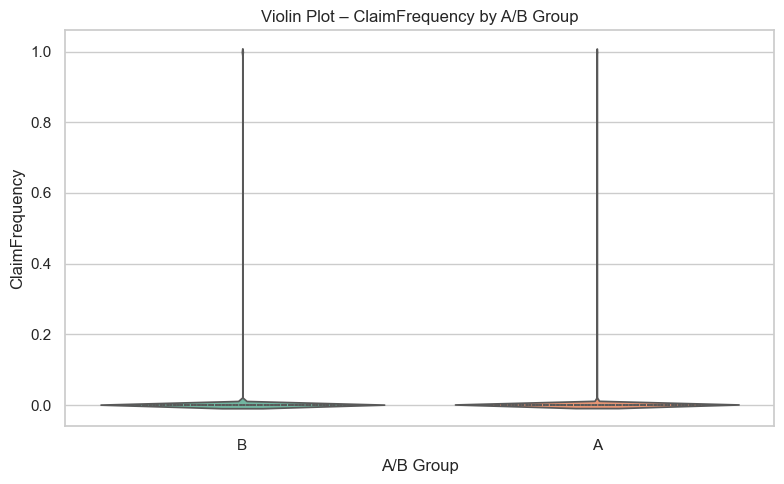

📦 Boxplot – ClaimFrequency


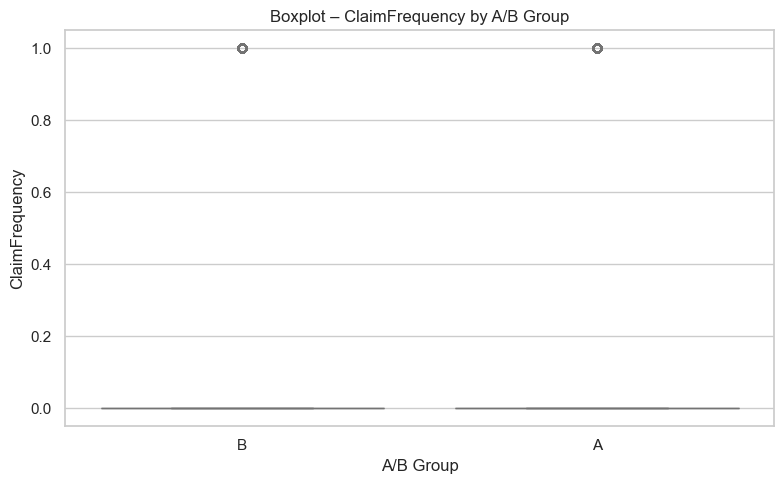

📊 Histogram Overlay – ClaimFrequency


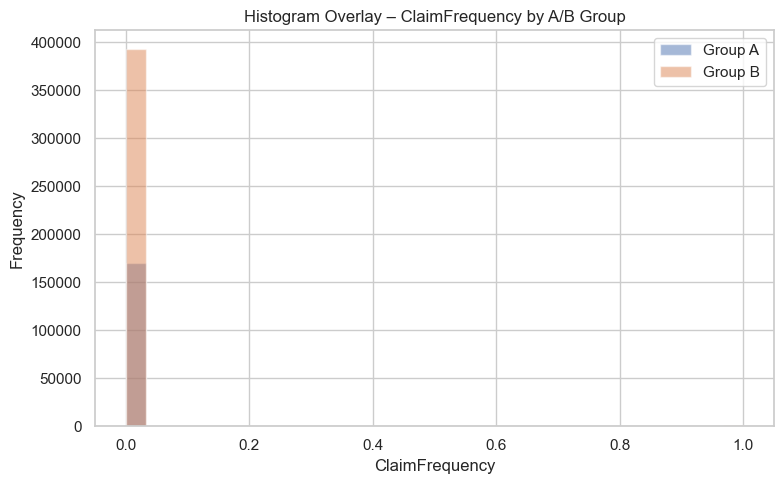


🔍 Visualizing ClaimSeverity by A/B Group...

🎻 Violin Plot – ClaimSeverity


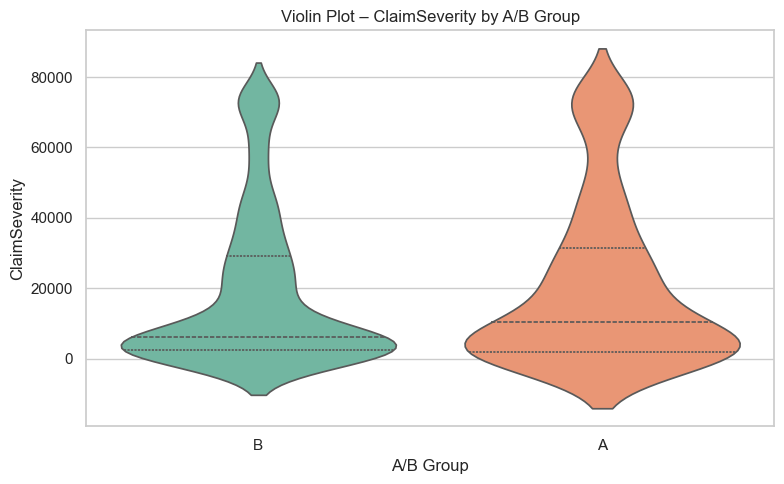

📦 Boxplot – ClaimSeverity


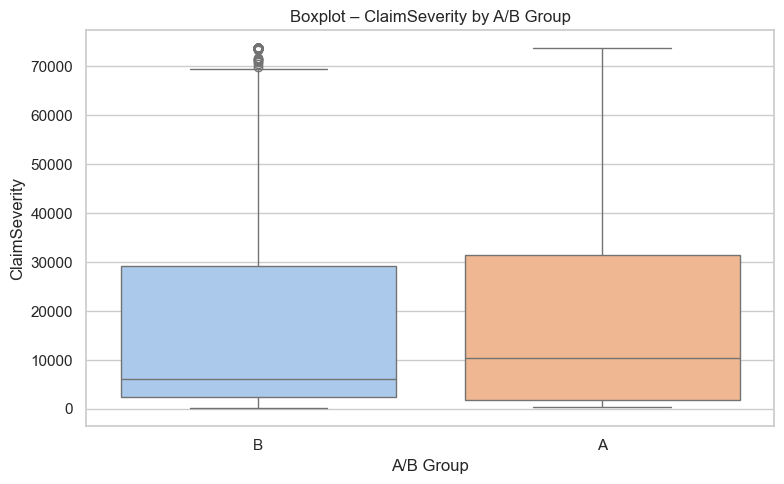

📊 Histogram Overlay – ClaimSeverity


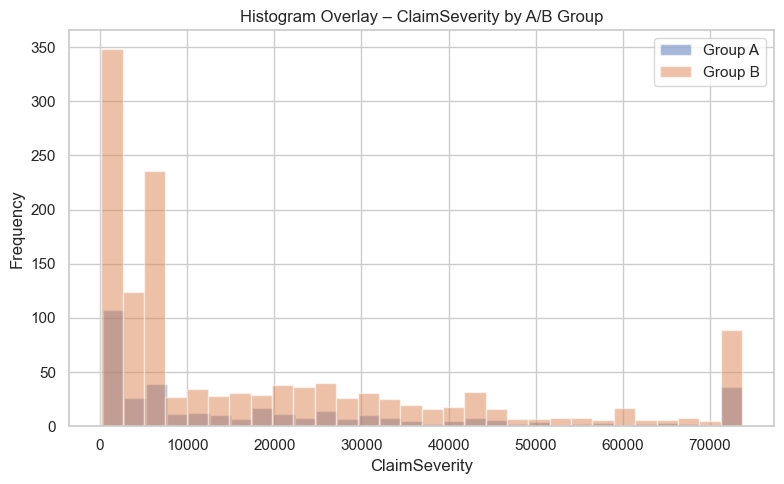


🔍 Visualizing Margin by A/B Group...

🎻 Violin Plot – Margin


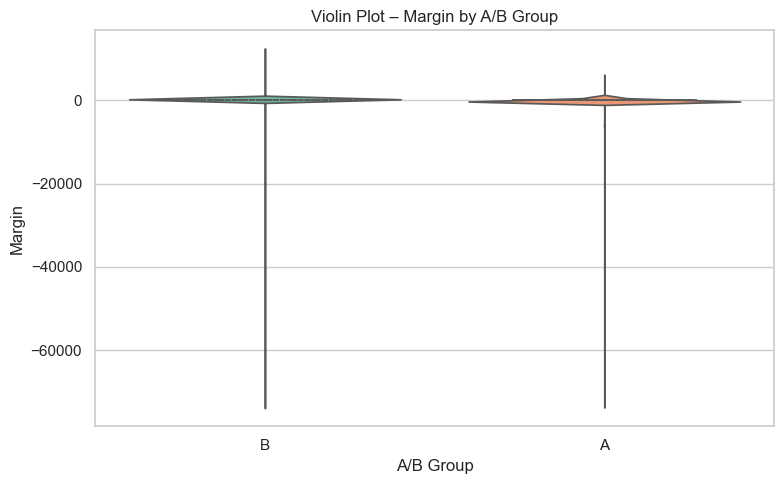

📦 Boxplot – Margin


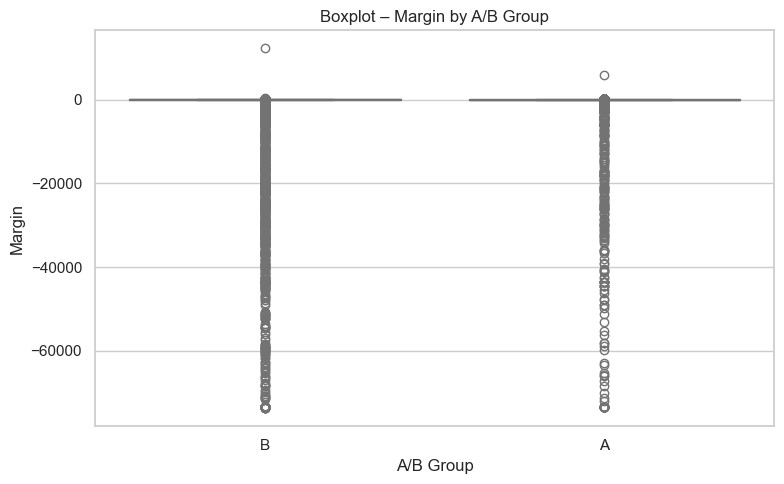

📊 Histogram Overlay – Margin


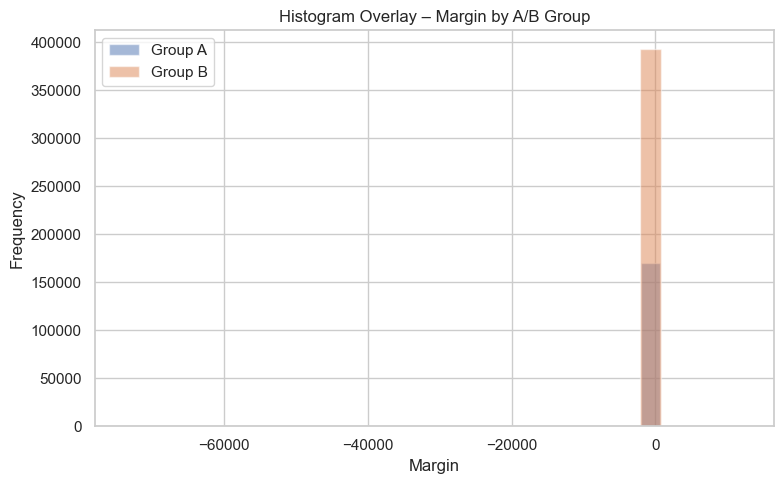

In [9]:
# ----------------------------------------------------------------------
# 🧪 Visualize KPI Distributions by A/B Group (Violin, Box, Histogram)
# ----------------------------------------------------------------------

from src.hypothesis_testing.visual_tester import VisualTester  # Modular plot class

# ✅ Initialize the visualizer with the segmented A/B dataframe
visualizer = VisualTester(df=province_df)

# ✅ Define the KPI metrics to visualize for WC (A) vs GT (B)
kpi_columns = ["ClaimFrequency", "ClaimSeverity", "Margin"]

# 🔁 Loop through each KPI metric and visualize distribution by A/B group
for metric in kpi_columns:
    print(f"\n🔍 Visualizing {metric} by A/B Group...\n")

    # 🎻 Violin Plot – distribution shape + IQR spread
    print(f"🎻 Violin Plot – {metric}")
    try:
        visualizer.plot_violin(metric)
    except Exception as e:
        print(f"❌ Failed to render violin plot for {metric}: {e}")

    # 📦 Boxplot – median, outliers, whiskers
    print(f"📦 Boxplot – {metric}")
    try:
        visualizer.plot_boxplot(metric)
    except Exception as e:
        print(f"❌ Failed to render boxplot for {metric}: {e}")

    # 📊 Histogram Overlay – raw shape comparison across A/B groups
    print(f"📊 Histogram Overlay – {metric}")
    try:
        visualizer.plot_histogram_overlay(metric)
    except Exception as e:
        print(f"❌ Failed to render histogram overlay for {metric}: {e}")